In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import statsmodels.api as sm
try:
    adj_close_df = pd.read_csv(r'E:\study\22fall\hf\data\hw1\SP500_components.csv',index_col=0)
except:
    #sp500 components
    sp_assets = pd.read_html(
            'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
    sym = sp_assets['Symbol'].str.replace('.','-').tolist()
    data = yf.download(tickers=sym,start = '2021-08-09',end = '2022-09-11')
    adj_close_df = data.iloc[:,:503]
    adj_close_df.columns = [i[1] for i in adj_close_df.columns]
    adj_close_df.to_csv(r'E:\study\22fall\hf\data\hw1\SP500_components.csv')
adj_ror_df = adj_close_df/adj_close_df.shift(1)-1
ror_10_treasure_float = 0.03319
print('pass')

pass


In [3]:
#functions
#allocation
def allocate(cash_float:float,weights_array:np.array,price_array:np.array)->tuple: #commission: 0.005/share
    cash_weighted_array = cash_float*weights_array
    share_array = np.floor(cash_weighted_array/(price_array+0.005))
    price_sum_float = np.sum(share_array*price_array+0.005*share_array)
    cash_float -= price_sum_float
    return cash_float,share_array

def momentum_factor(ror_df,window_int):
    ror_df = np.log(ror_df+1)
    momentum_factor_df = np.exp(ror_df.rolling(window_int,axis=0).sum())-1
    return momentum_factor_df

def sharp(ror_d_array):
    ror_y_float = np.exp(np.log(1+ror_d_array).sum() / (ror_d_array.shape[1]/252))-1
    std_y_float = np.std(ror_d_array)*np.sqrt(252)
    return (ror_y_float-0.03319)/std_y_float

def IC_analysis(factor_df,ror_df,method_str = 'pearson'):
    factor_df.dropna(axis=0,inplace=True,how='all')
    #ror multiindex & shift -1
    ror_shift_df = ror_df.shift(-1)
    ror_shift_df = ror_shift_df.reindex(factor_df.index,axis = 0)
    corrs_df = ror_shift_df.corrwith(factor_df,axis = 1,method = method_str)
    corrs_df.dropna(axis=0,inplace=True,how='all')
    corrs_array = corrs_df.values
    IC_mean_float = np.mean(corrs_array)
    IC_std_float = np.std(corrs_array)
    IC_IR_float = IC_mean_float/IC_std_float
    IC_pos_rate_float = len(corrs_array[corrs_array>0])/len(corrs_array)
    print(f'\nIC Analysis\nIC_mean: {IC_mean_float},\nIC_std: {IC_std_float},\nIC_IR: {IC_IR_float},\n(IC>0)%: {IC_pos_rate_float}')

def factor_ret(factor_df,ror_df):
    factor_df.dropna(axis=0, inplace=True, how='all')
    #20 days accumulate ror
    ror_accu_df = np.log(ror_df+1)
    ror_accu_df = np.exp(ror_accu_df.rolling(20,axis=0).sum())-1
    ror_shift_df = ror_accu_df.shift(-20).dropna(axis=0)
    idx_intersect_list = np.intersect1d(factor_df.index.tolist(),ror_shift_df.index.tolist()).tolist()
    ror_shift_df = ror_shift_df.reindex(idx_intersect_list, axis=0)
    factor_df = factor_df.reindex(idx_intersect_list,axis=0)
    #reg for factor ret
    factor_ret_list = []
    t_list = []
    for i in range(factor_df.shape[0]):
        X_array = factor_df.iloc[i,:].values
        y_array = ror_shift_df.iloc[i,:].values
        # nan detect
        nan_locX_array = np.where(np.isnan(X_array)==True)
        nan_locy_array = np.where(np.isnan(y_array)==True)
        nan_loc_array = np.union1d(nan_locy_array,nan_locX_array)
        X_array = np.delete(X_array,nan_loc_array)
        y_array = np.delete(y_array,nan_loc_array)
        #add constant
        X_array = sm.add_constant(X_array)
        model = sm.OLS(y_array,X_array)
        result = model.fit()
        t_val_float = result.tvalues[1]
        coef_float = result.params[1]
        factor_ret_list.append(coef_float)
        t_list.append(t_val_float)
    t_abs_array = np.abs(t_list)
    t_abs_mean_float = np.mean(t_abs_array)
    t_abs_significant_float = len(t_abs_array[t_abs_array>2])/len(t_abs_array)
    t_mean_float = np.mean(t_list)
    ret_mean_float = np.mean(factor_ret_list)
    print(f'\nRegression Analysis\nabs tvalue mean: {t_abs_mean_float}\nsignificance of t value( abs>2): {t_abs_significant_float}'
          f'\nt value mean: {t_mean_float}\nret mean: {ret_mean_float}')


In [4]:
momentum_df = momentum_factor(adj_ror_df,120)
IC_analysis(momentum_df,adj_ror_df,'spearman')
factor_ret(momentum_df,adj_ror_df)


IC Analysis
IC_mean: 0.009169094502031846,
IC_std: 0.3273080298591195,
IC_IR: 0.028013655839664014,
(IC>0)%: 0.5454545454545454

Regression Analysis
abs tvalue mean: 5.064160336535453
significance of t value( abs>2): 0.8222222222222222
t value mean: 0.22853740445418344
ret mean: 0.010487851159349075


Through IC and return analysis, we can see that that momentum factor constructed by 120 trade days' accumulate return
is effective right now, so I drop stocks with incomplete data and select 5 stocks with biggest momentum value to constru
ct the portfolio with equal weights.


In [4]:
#portfolio construction
# choose 5 stock with top X factor value with equal weight
nums_int = 5
cash_init_float = 1e8
end_dt_str = '2022-09-08'
bkt_period_int = 252
end_loc_int = np.where(adj_close_df.index==end_dt_str)[0][0]
beg_loc_int = end_loc_int-bkt_period_int

symbols_list = momentum_df.iloc[-1,:].sort_values().tail(nums_int+1).index.tolist()[:-1] #last one lack data
weights_array = np.array([1/nums_int]*nums_int)
price_array = adj_close_df.iloc[beg_loc_int,:][symbols_list].values
cash_float,share_array = allocate(cash_init_float,weights_array,price_array)

In [5]:
# cal portfolio mkt val
ror_df = adj_ror_df.iloc[beg_loc_int + 1:end_loc_int+1, :][symbols_list]
ror_array = ror_df.values
accu_ret_array = np.multiply.accumulate(ror_array + 1, axis=0)
stk_mkt_val_array = share_array.reshape(1,-1) * price_array.reshape(1,-1)
mkt_val_array = stk_mkt_val_array * accu_ret_array
mkt_val_array = np.concatenate((stk_mkt_val_array, mkt_val_array), axis=0)
portfolio_d_ret_array = np.diff(mkt_val_array, 1, axis=0)
portfolio_d_ret_cmb_array = portfolio_d_ret_array.sum(axis=1).reshape(-1, 1)
partial_sum_portfolio_ret_array = np.add.accumulate(portfolio_d_ret_array, 0)
portfolio_mv_array = np.sum(mkt_val_array, axis=1) + cash_float

In [6]:
# bmk ret
try:
    sp500_adj_close_df = pd.read_csv(r'E:\study\22fall\hf\data\hw1\SP500.csv',index_col=0)
except:
    data = yf.download(tickers='SPY',start = '2021-08-09',end = '2022-09-11')
    sp500_adj_close_df = data.iloc[:,-2]
    sp500_adj_close_df.to_csv(r'E:\study\22fall\hf\data\hw1\SP500.csv')
end_loc_int = np.where(sp500_adj_close_df.index==end_dt_str)[0][0]
beg_loc_int = end_loc_int-bkt_period_int
sp500_adj_ror_df = sp500_adj_close_df/sp500_adj_close_df.shift(1)-1
sp500_adj_ror_df.dropna(axis=0,inplace=True)
sp500_adj_ror_bkt_df = sp500_adj_ror_df.iloc[beg_loc_int + 1:end_loc_int + 1, :]
sp500_accu_ror_array = np.multiply.accumulate(sp500_adj_ror_bkt_df+1,axis=0).values
bmk_ret_array = cash_init_float * sp500_accu_ror_array
bmk_ret_array = np.concatenate((np.array(cash_init_float).reshape(1, 1), bmk_ret_array.reshape(-1, 1)))
bmk_d_ret_array = np.diff(bmk_ret_array, 1, axis=0)
partial_sum_bmk_ret_array = np.add.accumulate(bmk_d_ret_array, 0)

# gen dataset
d_ret_array = np.concatenate((portfolio_d_ret_cmb_array, bmk_d_ret_array), axis=1)

In [7]:
# metric ouput
portfolio_ror_array = np.matmul(weights_array.reshape(1, -1), ror_array.T)
portfolio_sharp_float = sharp(portfolio_ror_array)
sp500_adj_ror_bkt_array = sp500_adj_ror_bkt_df.values.reshape(1, -1)
bmk_sharp_float = sharp(sp500_adj_ror_bkt_array)
corrs_float = np.corrcoef(d_ret_array.T)

In [8]:
#cal beta
X_array = sm.add_constant((sp500_adj_ror_bkt_array-ror_10_treasure_float).reshape(-1,1))
y_array = (portfolio_ror_array-ror_10_treasure_float).reshape(-1,1)
model = sm.OLS(y_array,X_array)
result = model.fit()
beta_float = result.params[1]

In [9]:
print(f'corr: {corrs_float[0][1]}')
print(f'sharp:\n\tportfolio: {portfolio_sharp_float},\n\tbenchmark(SP500): {bmk_sharp_float}')
print(f'beta: {beta_float}')

corr: 0.10146023616008365
sharp:
	portfolio: 1.1328885994761588,
	benchmark(SP500): -0.5411262330954048
beta: 0.19836717197057901


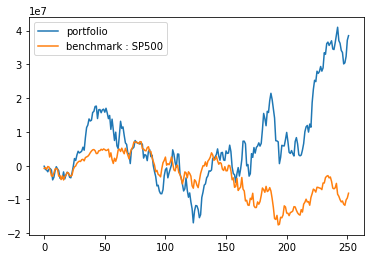

In [10]:
#plotting
plt.plot(np.sum(partial_sum_portfolio_ret_array,axis=1),label='portfolio')
plt.plot(partial_sum_bmk_ret_array,label='benchmark : SP500')
plt.legend()
plt.show()

Though momentum is relative effective right now, its effectiveness may quickly fade away since it is a well explored factor
 with a long history. Despite its effectiveness, not all stocks selected are satisfying and the portfolio may cause great drawdown
 under certain circumstance.

 Possible improvments:

1.If we can use market netural strategy, which is to short stocks with small momentum and long those with big
 momentum, then we may get a theoretically smooth pnl cureve.

2.If time allows, I can develop more factors and use them together to score each stock.Therefore, we may get a portfolio
 with better performance.

3.We can refine momentum factor by getting normalized factor with industry dummy variables and market cap .

4.Considering stocks volatility and covariance matrix with each other, we may employ mean variance function as objective
 function and some optimization algorithm to decide weights for each stock in the portfolio.